In [216]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None,E_UAV = None,E_UGV = None):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.E_UAV = E_UAV
        self.E_UGV = E_UGV
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS

    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    def select(node,waypoints):
        print(f"condistion: {node.children ,node.fully_expanded(waypoints)}" )
        while node.children and not node.fully_expanded(waypoints):
            # print(node.fully_expanded(waypoints))
            node = node.best_child(node)
            print("-----------selection--------------")
            node.traverse()
            print("-------end--------\n")
        return node

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}, Level: {self.level}, E_UAV: {self.E_UAV}, E_UGV: {self.E_UGV}, Visits: {self.visit_count}, Value: {self.value}")
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=1.41):
        """Calculates the UCB1 value for MCTS."""
        if self.visit_count == 0:
            return float('inf')
        parent_visits = self.parent.visit_count if self.parent is not None else 1
        return self.value / self.visit_count + exploration_constant * math.sqrt(
            math.log(parent_visits) / self.visit_count)

    def best_child(self,node):
        
        return min(self.children, key=lambda node: node.ucb1(), default=None)

    def fully_expanded(self,waypoints):
        """Checks if the node is fully expanded."""
        return self.level == len(waypoints) - 1  # -1 since the sequence length is one less than waypoints

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward




In [197]:
def calculate_UAV_inter_distances_inter(UAV_path):
    UAV_inter_distances = 0
    group_distance=0
    # print(f"what I got in function:{UAV_path}")
    for i in range(len(UAV_path) - 1):
        group_distance += compute_distance(UAV_path[i], UAV_path[i + 1])
    UAV_inter_distances=group_distance
    # print(f"UAV_path:{UAV_path},UAV_inter_distances{UAV_inter_distances}")
    return UAV_inter_distances

In [198]:
def compute_path_for_one_point(ordered_points, point_index, radius, speed_ugv, speed_uav, survey_time):
    if point_index <= 0 or point_index >= len(ordered_points) - 1:
        raise ValueError("Invalid point index. It should be between 1 and len(ordered_points) - 2.")
    
    UGV_outer_path = []
    UGV_path = []
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    # final_wait_set = []
    radius_set = []
    final_wait_time = 0 
    point = ordered_points[point_index]
    
    # Assuming angle_between_points and point_on_circle functions are defined previously
    angle = angle_between_points(ordered_points[point_index - 1], ordered_points[point_index])
    nextangle = angle_between_points(ordered_points[point_index], ordered_points[point_index + 1])
    chord_start = point_on_circle(ordered_points[point_index], angle - np.pi, radius)
    chord_end = point_on_circle(ordered_points[point_index], nextangle, radius)
    radius_set.append(radius)
    
    if point_index > 1 and circles_overlap(ordered_points[point_index], radius, ordered_points[point_index - 1], radius):
        chord_start = prev_chord_end

    # Assuming find_meeting_point_with_survey_final function is defined previously
    final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
        ordered_points[point_index], radius, chord_start, chord_end, 
        speed_ugv, speed_uav, survey_time
    )
    final_wait_time = final_wait_time
    
    if chord_start:
        UAV_path_segment = [chord_start, point, final_meeting_point]
        UAV_path.append(UAV_path_segment)
        UGV_path.append(chord_start)

        # Assuming calculate_UAV_inter_distances_inter function is defined previously
        UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
        if point_index == 1:
            UGV_outer_path.append([ordered_points[0], chord_start])
        else:
            UGV_outer_path.append([prev_chord_end, chord_start])
        # print(f"UGV_outer_path:{UGV_outer_path}")
    if chord_end:
        UGV_path.append(chord_end)

    # Assuming compute_distance function is defined previously
    inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
    inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
    UGVD_inter_without_drone.append(inter_distance_without_drone)
    UGVD_inter_with_drone.append(inter_distance_with_drone)
    
    return radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time

# Note: This function assumes the existence of functions like angle_between_points, point_on_circle, 
# find_meeting_point_with_survey_final, etc. which are not provided here. So, this function won't run as-is without those definitions.


In [199]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math
x = 3  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 1
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets
# print(UAV_E_s_cost)
# waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
# # waypoints = [(20,10), (10,10),(15,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
waypoints = [(20,10), (10,10), (10,30), (20,30)]
plan_output = "0 -> 1 -> 2 -> 3 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(max_radius, 1.0, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


In [208]:
def add_node_with_random_radius(parent, nodes_in_order, node_counter, r):
    # print(f"data_in nodes_in_order :{nodes_in_order}")
    waypoint_index = parent.level + 1
    
    # print(f"waypoint_index:{waypoint_index},with radius:{r}")
    if waypoint_index >= len(nodes_in_order):
        return
    if waypoint_index == 1: # starting point, no charging need to be cal for the begining path
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_out_distance = compute_distance(ordered_points[0], UAV_path[0][0])
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        UGV_distance = UGV_out_distance + UGV_inter_distance
        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost

        charging_distance = UGVD_inter_with_drone[0]
        
        UGV_energy_remaining = Total_E_UGV - UGV_Trip_Cost
        UAV_energy_remaining = Total_E_UAV - UAV_Trip_Cost
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            return  # Indicating mission failed for both
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            pass_flag = 1
            pass
        else:
            pass_flag = 0
        total_time = parent.total_time  + final_wait_time +UGV_distance / speed_ugv

    elif waypoint_index == (len(nodes_in_order) -1): # Ending point, don't charge the drone on the wayback
        
        UAV_path = []
        final_wait_time = 0
        UGV_path = [parent.end_point,ordered_points[-1]]
        UGV_distance = compute_distance(parent.end_point,ordered_points[-1])
        total_time = parent.total_time + UGV_distance / speed_ugv 

        UGV_energy_remaining =parent.E_UGV
        UAV_energy_remaining =parent.E_UAV
        
        UGV_Trip_Cost = UGV_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = 0
        UGV_energy_remaining -= UGV_Trip_Cost
        if UGV_energy_remaining < 0:
            pass_flag = 1
            pass
        else:
            pass_flag = 2
        
    else: #Any Mid point on the way 
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        # print(f"parent.end_point:{parent.end_point}")
        UGV_out_distance = compute_distance(parent.end_point,UGV_path[0])

        UGV_distance = UGV_out_distance + UGV_inter_distance

        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost
        
        UAV_energy_remaining = parent.E_UAV
        UGV_energy_remaining = parent.E_UGV
        
        charging_distance = UGV_out_distance
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        UGV_energy_remaining = UGV_energy_remaining - UGV_Trip_Cost
        UAV_energy_remaining = UAV_energy_remaining - UAV_Trip_Cost
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            pass_flag = 1 
            pass
        else: 
            pass_flag = 0   
            total_time = parent.total_time  + UGV_distance / speed_ugv + final_wait_time

        
        
    if pass_flag == 1:
        pass
    elif pass_flag == 2:
        node_counter += 1 
        child = Node(id=node_counter, radius=None, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic
         # Increment global node ID counter
    else:
        child = Node(id=node_counter, radius=r, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic
        node_counter += 1  # Increment global node ID counter
        # print(f"before recursive nodes_in_order :{nodes_in_order}")
        
        
        return  node_counter      
       
    
   

In [201]:
import random

def simulate(node,         e(reward)
        # print(f"backpropagate reward :{reward},to node :{node.id}")
        node = node.parent

def expand_mcts(node, nodes_in_order,node_counter,r):

    node_counter = add_node_with_random_radius(node, nodes_in_order, node_counter, r)

    return node, node_counter if node.children else None

In [217]:
def MCTS_v2(root, nodes_in_order,waypoints, iterations=15):
    node_counter_old = 0
    # root = Node(id=0, radius=radii, total_time=0)
    print(iterations)
    for _ in range(int(iterations)):
        # 1. Selection
        r = random.choice(radii)
        node = Node.select(root,waypoints)

        # 2. Expansion
        node,node_counter = expand_mcts(node, nodes_in_order,node_counter_old,r)
        # print(f"node_counter at MCTS_V2:{node_counter}")
        if node_counter == None:  # If no expansion was possible, skip this iteration
            print("not able to expand")
            continue
        else:
        # 3. Simulation
            node_counter_old = node_counter
        # print(waypoints)
            reward = simulate(node,waypoints)  # We negate since we want to minimize total_time
            # print(f"reward:{reward}")
        # 4. Backpropagation
        backpropagate(node, reward)
    return root.best_child(node)

In [218]:
root = Node(id=0, radius=None, total_time=0)
nodes_in_order = plan_output.split()
nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
# print(f"nodes_in_order :{nodes_in_order},waypoints:{waypoints}")

best_node = MCTS_v2(root, nodes_in_order,waypoints)

15
condistion: ([], False)
condistion: ([<__main__.Node object at 0x7fc98489fd30>], False)
-----------selection--------------
Node ID: 0, Radius: 3.0, Total Time: 1.1242640687119283, Level: 1, E_UAV: 7031.991476329811, E_UGV: 489369.4913472367, Visits: 0, Value: 0.0
-------end--------

condistion: ([<__main__.Node object at 0x7fc98489fd30>], False)
-----------selection--------------
Node ID: 0, Radius: 3.0, Total Time: 1.1242640687119283, Level: 1, E_UAV: 7031.991476329811, E_UGV: 489369.4913472367, Visits: 1, Value: 0.0
Node ID: 1, Radius: 5.0, Total Time: 3.031370849898476, Level: 2, E_UAV: 4540.097098824646, E_UGV: 463183.9684022943, Visits: 0, Value: 0.0
-------end--------

-----------selection--------------
Node ID: 1, Radius: 5.0, Total Time: 3.031370849898476, Level: 2, E_UAV: 4540.097098824646, E_UGV: 463183.9684022943, Visits: 0, Value: 0.0
-------end--------

not able to expand
condistion: ([<__main__.Node object at 0x7fc98489fd30>], False)
-----------selection--------------


In [204]:
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])
    
    # Dynamic figure size
    num_nodes = len(all_nodes)
    num_levels = len(level_counts)
    fig_width = max(10, num_nodes * 0.5)
    fig_height = max(5, num_levels * 2)
    plt.figure(figsize=(fig_width, fig_height))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()


In [205]:
root.traverse()

Node ID: 0, Radius: None, Total Time: 0, Level: 0, E_UAV: None, E_UGV: None, Visits: 3, Value: 0.0
Node ID: 0, Radius: 1.0, Total Time: 1.1333333333333333, Level: 1, E_UAV: 10000.0, E_UGV: 489868.6291501015, Visits: 2, Value: 0.0
Node ID: 1, Radius: 3.0, Total Time: 3.1575974020452615, Level: 2, E_UAV: 7031.991476329811, E_UGV: 465238.1204973382, Visits: 1, Value: 0.0
Node ID: 2, Radius: 3.0, Total Time: 3.98186147075719, Level: 3, E_UAV: 3063.9829526596222, E_UGV: 453607.61184457486, Visits: 0, Value: 0.0
Node ID: 4, Radius: None, Total Time: 5.68186147075719, Level: 4, E_UAV: 3063.9829526596222, E_UGV: 436607.61184457486, Visits: 0, Value: 0.0
Node ID: 4, Radius: None, Total Time: 5.68186147075719, Level: 4, E_UAV: 3063.9829526596222, E_UGV: 436607.61184457486, Visits: 0, Value: 0.0
Node ID: 4, Radius: None, Total Time: 5.68186147075719, Level: 4, E_UAV: 3063.9829526596222, E_UGV: 436607.61184457486, Visits: 0, Value: 0.0
Node ID: 4, Radius: None, Total Time: 5.68186147075719, Level:

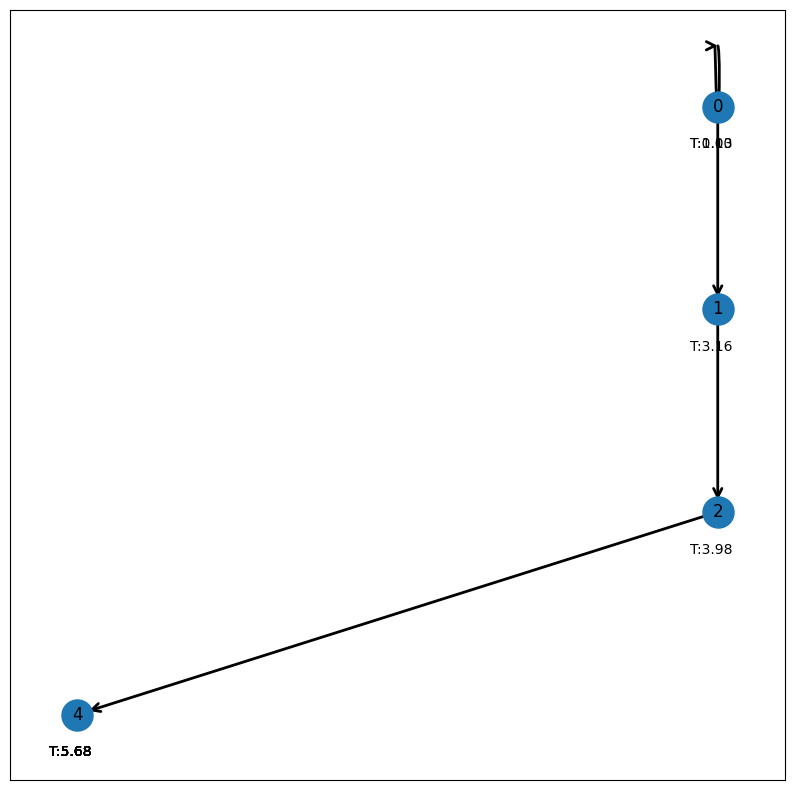

In [206]:
draw_tree(root)